In [46]:
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [118]:
#dpath = 'yale_subset_719'
rows = 192
cols = 168

img_files = glob.glob('yale_subset_719/*.bmp')
nimages = len(img_files)
imgs = np.zeros((rows * cols, nimages), dtype=np.uint8)

colseq = np.arange(nimages)
for i, picture in zip(colseq, img_files):
    imgs[:, i] = np.reshape(plt.imread(picture), (1, -1))

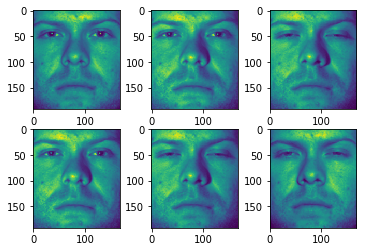

In [119]:
#plt.imshow(plt.imread(img_files[1]))
#plt.imshow(np.reshape(imgs[:,1], (rows,-1)))

fig, axes = plt.subplots(2, 3)
for i in np.arange(2):
    for j in np.arange(3):
        axes[i, j].imshow(np.reshape(imgs[:, i+j], (rows, -1)))

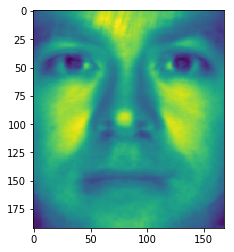

In [124]:
avg_face = np.sum(imgs, axis=1) / nimages
avg_face.astype(np.uint8)
plt.imshow(np.reshape(avg_face, (rows, -1)))

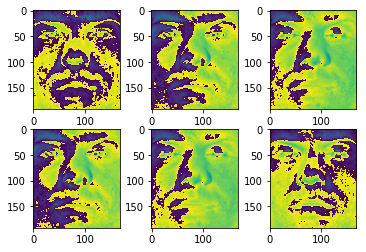

In [129]:
A = np.zeros((rows * cols, nimages), dtype=np.uint8)
for i in np.arange(nimages):
    A[:, i] = imgs[:, i] - avg_face
    
fig, axes = plt.subplots(2, 3)
for i in np.arange(2):
    for j in np.arange(3):
        axes[i, j].imshow(np.reshape(A[:, i+j], (rows, -1)))

In [182]:
L = np.matmul(np.atleast_2d(A).T.astype(float), A.astype(float))
D, V = np.linalg.eig(L)
#D = np.sort(np.diag(D))

In [156]:
np.sort(np.diag(D))
#np.sort(np.diag(D)[::-1])

array([[     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,  13747.32073042],
       [ -1478.69279809,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [ -1443.56726609,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       ..., 
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,    110.75467948],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,     36.68605476],
       [  -244.65459956,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

In [184]:
D

array([  5.86172217e+10,   5.06380405e+09,   2.75882060e+09,
         2.43522481e+09,   1.53078774e+09,   1.31935814e+09,
         1.04483141e+09,   7.87042310e+08,   6.86374285e+08,
         6.53485441e+08,   4.88365049e+08,   4.66403519e+08,
         4.53024901e+08,   4.09372940e+08,   3.78753498e+08,
         3.74384547e+08,   3.50068910e+08,   3.34271406e+08,
         3.13556314e+08,   3.07122217e+08,   2.91531214e+08,
         2.85232358e+08,   2.75237510e+08,   2.53774735e+08,
         2.43867361e+08,   2.40098158e+08,   2.33012260e+08,
         2.23152340e+08,   2.19546052e+08,   2.11449465e+08,
         2.09537357e+08,   1.97781971e+08,   1.95975206e+08,
         1.93547587e+08,   1.86769123e+08,   1.91264185e+08,
         1.82720228e+08,   1.76662607e+08,   1.69588185e+08,
         1.67509856e+08,   1.61035446e+08,   1.64435480e+08,
         4.08342298e+07,   1.55840303e+08,   1.52795204e+08,
         4.53082397e+07,   1.52134965e+08,   4.69138942e+07,
         1.49993860e+08,

In [170]:
np.array([[1,2,3], [4,5,6], [7,8,9]]).dot(np.array([[1,1,1], [1,1,1], [1,1,1]]))
np.atleast_2d(np.array([[1,2,3], [4,5,6], [7,8,9]])).T.conj()

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])